In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import torch
import matplotlib.pyplot as plt

In [2]:
x_min = - 600_000
x_max = 400_000
y_min = - 1_400_000
y_max = - 400_000

# Region is fixed - just load
# REDO_BEDMAP_CROP = True
REDO_BEDMAP_CROP = False

# Takes ~5 minutes to run
if REDO_BEDMAP_CROP:
    # 82 M data points
    bedmap123 = pd.read_csv("/home/kim/data/bedmap_raw_data/bedmap123.csv")
    # Crop to the region of interest: HERE ~ 4 M subset
    bedmap123_ross = bedmap123[
        (bedmap123["x"] > x_min) & (bedmap123["x"] < x_max) & (bedmap123["y"] > y_min) & (bedmap123["y"] < y_max)]
    # Save 
    bedmap123_ross.to_csv("/home/kim/data/bedmap_raw_data/bedmap123_ross.csv", index = False)

else: 
    # Just load
    bedmap123_ross = pd.read_csv("/home/kim/data/bedmap_raw_data/bedmap123_ross.csv")

In [3]:
# 5.8 M data points
print(bedmap123_ross.shape)
bedmap123_ross.head()

(5790926, 9)


,lon,lat,x,y,s,t,b,b_inferred,source
0,-162.2167,-78.17500,-393747.895145,-1.227610e+06,43.0,257.0,-607.0,False,BEDMAP1_1966-2000_AIR_BM1.csv
1,-163.0000,-78.78833,-357254.891928,-1.168528e+06,197.0,415.0,-218.0,True,BEDMAP1_1966-2000_AIR_BM1.csv
2,-164.8333,-78.91666,-316007.544874,-1.165778e+06,48.0,369.0,-425.0,False,BEDMAP1_1966-2000_AIR_BM1.csv
3,-168.6500,-79.15334,-232601.272638,-1.158792e+06,59.0,384.0,-539.0,False,BEDMAP1_1966-2000_AIR_BM1.csv
4,-171.5167,-79.11667,-174949.002700,-1.172950e+06,49.0,328.0,-695.0,False,BEDMAP1_1966-2000_AIR_BM1.csv


# Show all data in the area

(11582, 9)


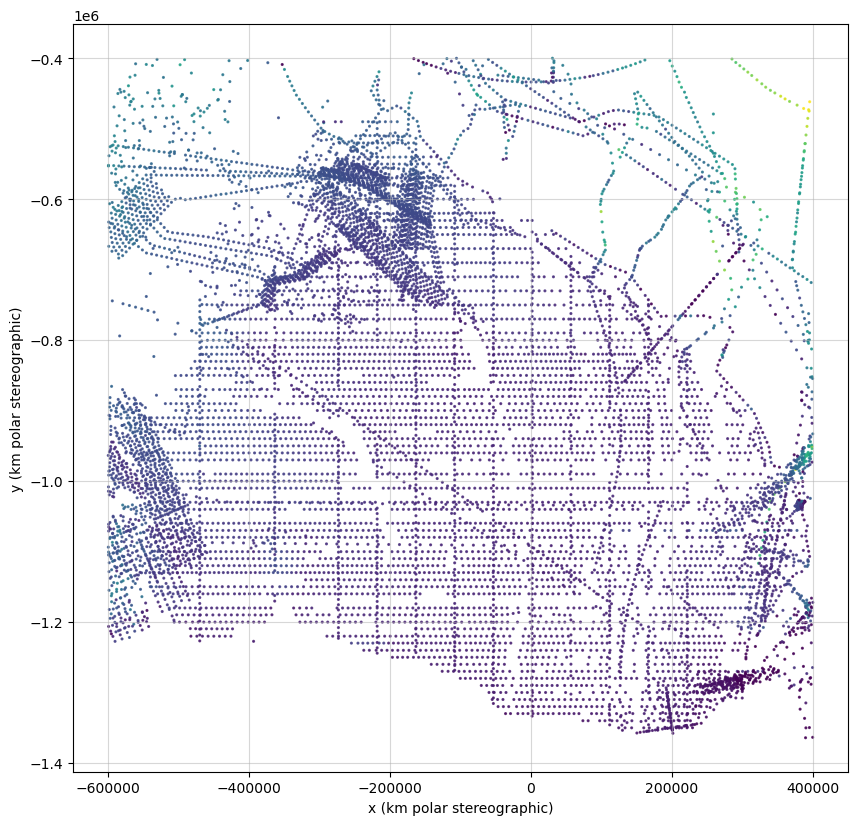

In [4]:
SUBSAMPLE_RATE = 500
# subsample to reduce number of data points
bedmap123_ross_ss = bedmap123_ross[::SUBSAMPLE_RATE]
print(bedmap123_ross_ss.shape)

fig, ax = plt.subplots(figsize = (10, 10))

ax.scatter(
    bedmap123_ross_ss['x'], 
    bedmap123_ross_ss['y'], 
    c = bedmap123_ross_ss['t'], 
    s = 1.5, alpha = 0.8, cmap = 'viridis')

# Optional: label axes to clarify units
ax.set_xlabel("x (km polar stereographic)")
ax.set_ylabel("y (km polar stereographic)")

ax.set_aspect('equal')
ax.grid(True, alpha = 0.5)

# Subset ice shelf data for training _onself

In [5]:
tighter_ice_shelf_mask = xr.load_dataarray("data/tighter_ice_shelf_mask.nc")

In [6]:
mask_at_points = tighter_ice_shelf_mask .interp(
    x = ("points", bedmap123_ross["x"].values),
    y = ("points", bedmap123_ross["y"].values),
    # nearest is fast
    method = "nearest"
)

# Step 2: Convert to numpy array for filtering
mask_values = mask_at_points.values

# Step 3: Subset DataFrame where mask==3
bedmap123_ross_onshelf = bedmap123_ross[mask_values == 3]

# Reduced to 3M points
print(bedmap123_ross_onshelf.shape)

(3260561, 9)


(32606, 9)


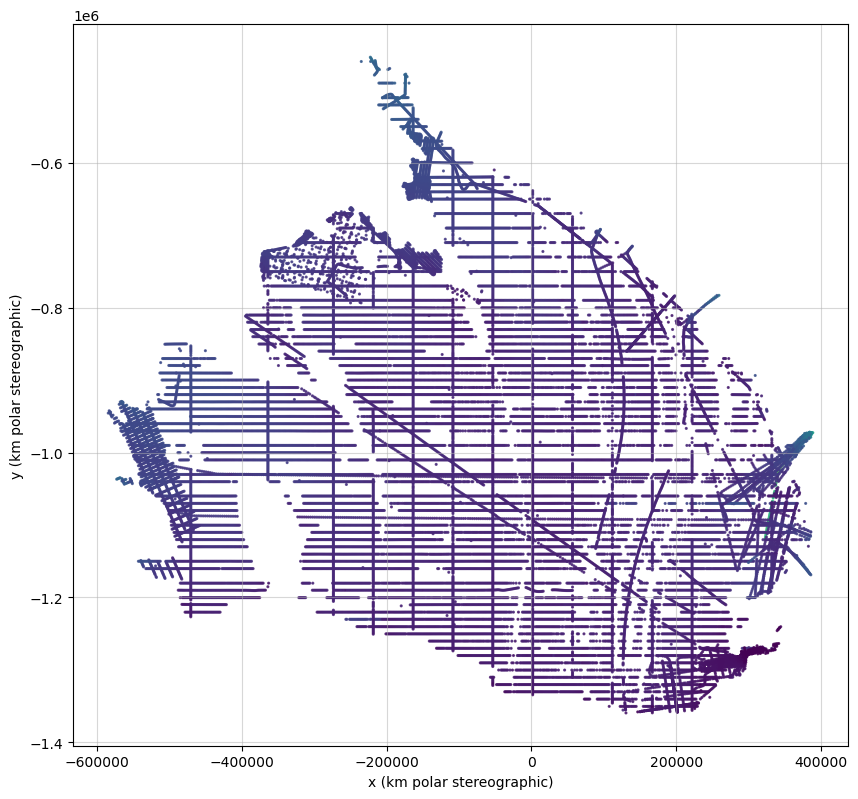

In [7]:
SUBSAMPLE_RATE = 100
# subsample to reduce number of data points
bedmap123_ross_onshelf_ss = bedmap123_ross_onshelf[::SUBSAMPLE_RATE]
print(bedmap123_ross_onshelf_ss.shape)

fig, ax = plt.subplots(figsize = (10, 10))

ax.scatter(
    bedmap123_ross_onshelf_ss['x'], 
    bedmap123_ross_onshelf_ss['y'], 
    c = bedmap123_ross_onshelf_ss['t'], 
    s = 1.5, alpha = 0.8, cmap = 'viridis')

# Optional: label axes to clarify units
ax.set_xlabel("x (km polar stereographic)")
ax.set_ylabel("y (km polar stereographic)")
ax.set_aspect('equal')
plt.savefig("figures/ice_thickness_points_onshelf.png", dpi = 300, bbox_inches = "tight")
ax.grid(True, alpha = 0.5)

# Combine into flux tensors

- rescale to [0, 1]
- rescale fluxes
- remove nans

## Firn correction

In [8]:
# Load meta data which contains firn adjustment info
meta = pd.read_csv("/home/kim/data/bedmap_raw_data_test/bedmap123_metadata.csv")

# Extract float
meta["firn_correction"] = meta.firn.str.extract(r"([-+]?\d*\.?\d+)").astype(float)
# Replace -9999 with 0.0 (We assume this means "zero" adjustment applied so far.)
meta["firn_correction"] = meta["firn_correction"].replace(-9999, 0.0)
# Calculate remaining delta (we correct all data to have a firn correction of 10)
# t_corrected = t_observed - 10

UNIVERSAL_FIRN_CORRECTION = 10.0
meta["firn_correction_delta"] = meta["firn_correction"] - UNIVERSAL_FIRN_CORRECTION

# Create lookup dictionary from meta
firn_delta_lookup = dict(zip(meta["source"], meta["firn_correction_delta"]))

# Add the correction delta to the thickness points
# NOTE: Create fa (firn adjusted) variable
bedmap123_ross_onshelf["t_fa"] = (
    bedmap123_ross_onshelf["t"] + bedmap123_ross_onshelf["source"].map(firn_delta_lookup)
)
# No need to save because we remove outliers
# bedmap123_ross_onshelf.to_csv("data/bedmap123_ross_onshelf_3M.csv", index = False)

/tmp/ipykernel_64689/2328630528.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bedmap123_ross_onshelf["t_fa"] = (


In [9]:
# First normalize into [0, 1]
bedmap123_ross_onshelf["x_norm"] = (bedmap123_ross_onshelf["x"] - x_min) / (x_max - x_min)
bedmap123_ross_onshelf["y_norm"] = (bedmap123_ross_onshelf["y"] - y_min) / (y_max - y_min)

/tmp/ipykernel_64689/2868564733.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bedmap123_ross_onshelf["x_norm"] = (bedmap123_ross_onshelf["x"] - x_min) / (x_max - x_min)
/tmp/ipykernel_64689/2868564733.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bedmap123_ross_onshelf["y_norm"] = (bedmap123_ross_onshelf["y"] - y_min) / (y_max - y_min)


# Outlier Removal 1: Zoom in lower left calving front

In [10]:
zoom_x_min = 0.32
zoom_x_max = 0.40
zoom_y_min = 0.15
zoom_y_max = 0.20

# Apply bounding box mask
mask = (
    (bedmap123_ross_onshelf["x_norm"] >= zoom_x_min) & (bedmap123_ross_onshelf["x_norm"] <= zoom_x_max) &
    (bedmap123_ross_onshelf["y_norm"] >= zoom_y_min) & (bedmap123_ross_onshelf["y_norm"] <= zoom_y_max)
)

bedmap123_zoom = bedmap123_ross_onshelf[mask]

print(bedmap123_zoom.shape)

(19468, 12)


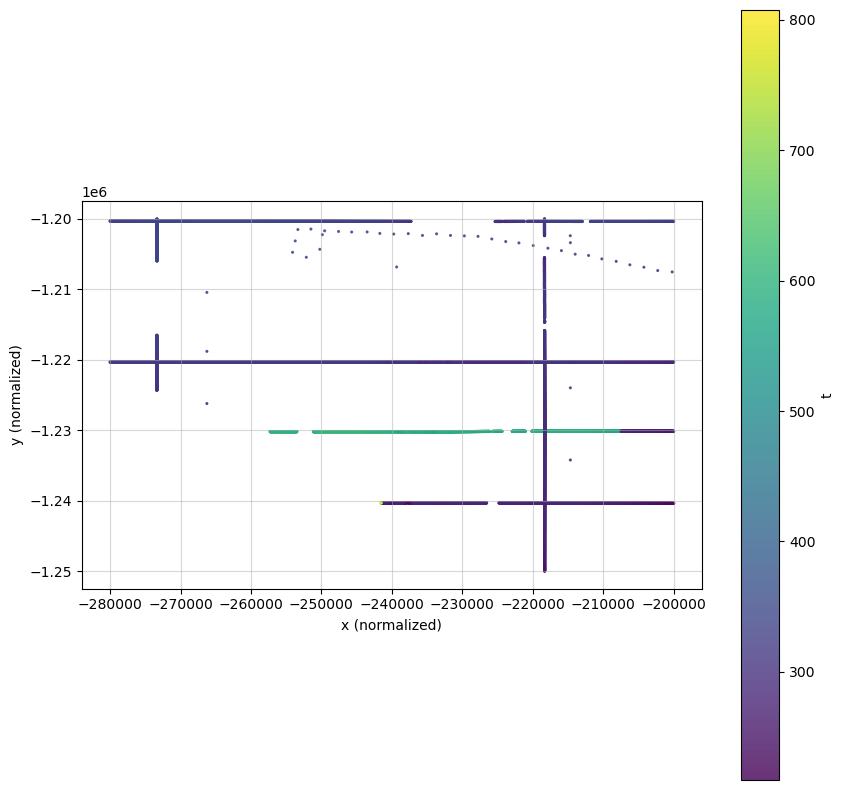

In [11]:
# Plot zoomed region
fig, ax = plt.subplots(figsize = (10, 10))

sc = ax.scatter(
    bedmap123_zoom["x"], 
    bedmap123_zoom["y"], 
    c = bedmap123_zoom["t_fa"], 
    s = 1.5, alpha = 0.8, cmap = "viridis"
)

ax.set_xlabel("x (normalized)")
ax.set_ylabel("y (normalized)")
ax.set_aspect("equal")
ax.grid(True, alpha = 0.5)
plt.colorbar(sc, ax = ax, label = "t")
plt.show()

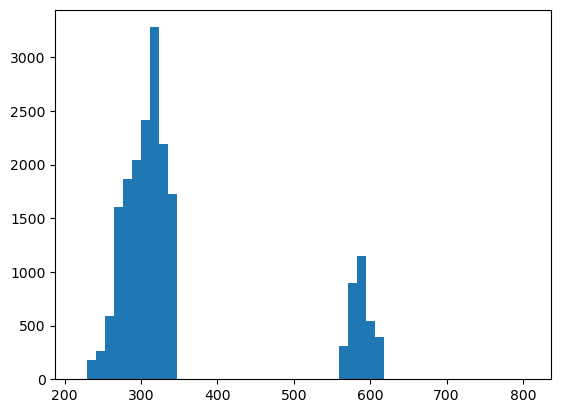

In [12]:
# seems like an outlier
plt.hist(bedmap123_zoom["t_fa"], bins = 50)
plt.show()

In [13]:
outlier_mask = (
    (bedmap123_ross_onshelf["x_norm"] >= zoom_x_min) & (bedmap123_ross_onshelf["x_norm"] <= zoom_x_max) &
    (bedmap123_ross_onshelf["y_norm"] >= zoom_y_min) & (bedmap123_ross_onshelf["y_norm"] <= zoom_y_max) &
    (bedmap123_ross_onshelf["t_fa"] > 500)
)

In [14]:
print("Removing N =", bedmap123_ross_onshelf[outlier_mask].shape[0], "observation.")

Removing N = 3288 observation.


In [15]:
# All from LDEO_2015_ROSETTA_AIR_BM3.csv
# Remove and overwrite
bedmap123_ross_onshelf_rm1 = bedmap123_ross_onshelf[~outlier_mask]
# No need to save because we remove more outliers first
# takes ~ 2 min
# bedmap123_ross_onshelf_rm1.to_csv("data/bedmap123_ross_onshelf_3M.csv", index = False)

# Outlier removal 2: Zoom into mid right horizontal line

In [16]:
zoom_x_min = 0.65
zoom_x_max = 1.0
zoom_y_min = 0.3
zoom_y_max = 0.35

# Apply bounding box mask
mask = (
    (bedmap123_ross_onshelf_rm1["x_norm"] >= zoom_x_min) & (bedmap123_ross_onshelf_rm1["x_norm"] <= zoom_x_max) &
    (bedmap123_ross_onshelf_rm1["y_norm"] >= zoom_y_min) & (bedmap123_ross_onshelf_rm1["y_norm"] <= zoom_y_max)
)

bedmap123_zoom = bedmap123_ross_onshelf_rm1[mask]

print(bedmap123_zoom.shape)

(109072, 12)


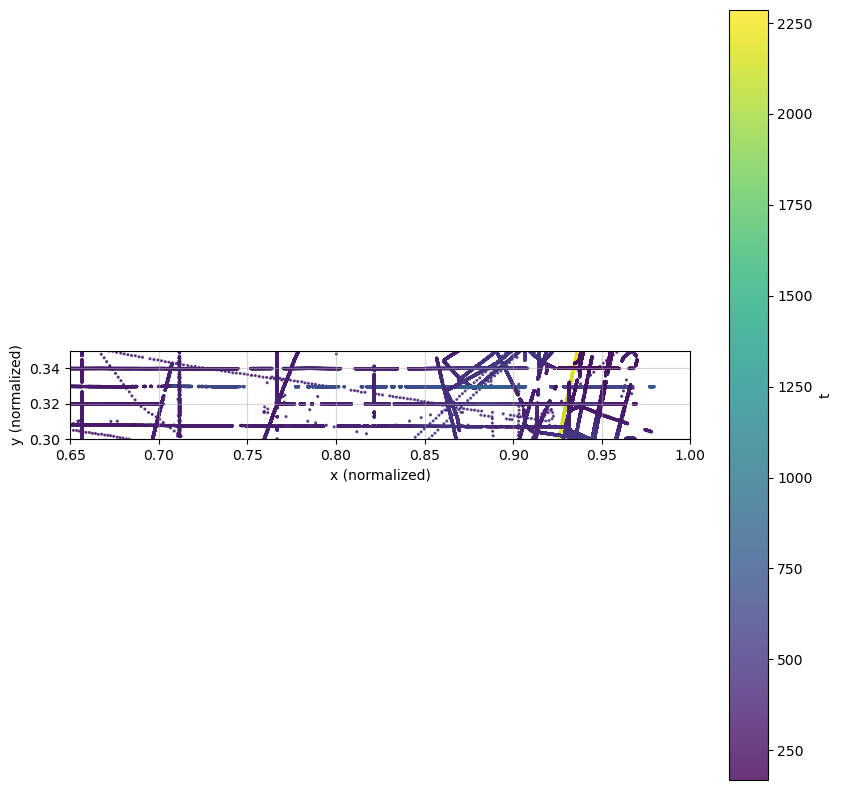

In [17]:
# Plot zoomed region
fig, ax = plt.subplots(figsize = (10, 10))

sc = ax.scatter(
    bedmap123_zoom["x_norm"], 
    bedmap123_zoom["y_norm"], 
    c = bedmap123_zoom["t_fa"], 
    s = 1.5, alpha = 0.8, cmap = "viridis"
)

ax.set_xlabel("x (normalized)")
ax.set_ylabel("y (normalized)")
ax.set_aspect("equal")
ax.grid(True, alpha = 0.5)
ax.set_xlim(zoom_x_min, zoom_x_max)
ax.set_ylim(zoom_y_min, zoom_y_max)
plt.colorbar(sc, ax = ax, label = "t")
plt.show()

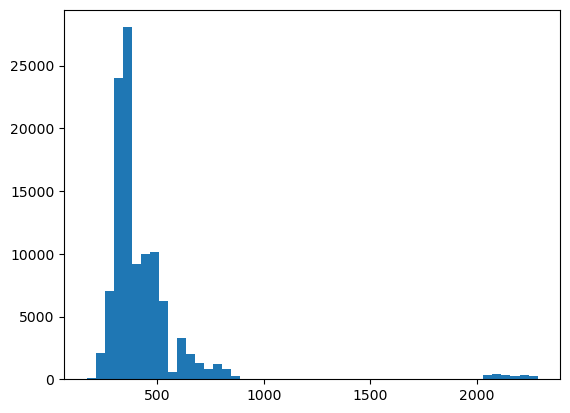

In [18]:
# clear bimodal distribution
plt.hist(bedmap123_zoom["t_fa"], bins = 50)
plt.show()

In [19]:
outlier_mask = (
    (bedmap123_ross_onshelf_rm1["x_norm"] >= zoom_x_min) & (bedmap123_ross_onshelf_rm1["x_norm"] <= zoom_x_max) &
    (bedmap123_ross_onshelf_rm1["y_norm"] >= zoom_y_min) & (bedmap123_ross_onshelf_rm1["y_norm"] <= zoom_y_max) &
    (bedmap123_ross_onshelf_rm1["t_fa"] > 600)
)

# Add same extra points (18 obs)
outlier_mask_extra = (
    (bedmap123_ross_onshelf_rm1["x_norm"] >= 0.67) & (bedmap123_ross_onshelf_rm1["x_norm"] <= 0.75) &
    (bedmap123_ross_onshelf_rm1["y_norm"] >= 0.3) & (bedmap123_ross_onshelf_rm1["y_norm"] <= 0.35) &
    (bedmap123_ross_onshelf_rm1["t_fa"] > 450)
)

# Add another cluster of points further to the right
outlier_mask_extra_extra = (
    (bedmap123_ross_onshelf_rm1["x_norm"] >= 0.9) & (bedmap123_ross_onshelf_rm1["x_norm"] <= 1.0) &
    (bedmap123_ross_onshelf_rm1["y_norm"] >= 0.32) & (bedmap123_ross_onshelf_rm1["y_norm"] <= 0.34) &
    (bedmap123_ross_onshelf_rm1["t_fa"] > 500)
)

# Combine masks
outlier_mask = outlier_mask | outlier_mask_extra | outlier_mask_extra_extra

In [20]:
print("Removing N =", bedmap123_ross_onshelf_rm1[outlier_mask].shape[0], "observation.")

Removing N = 11867 observation.


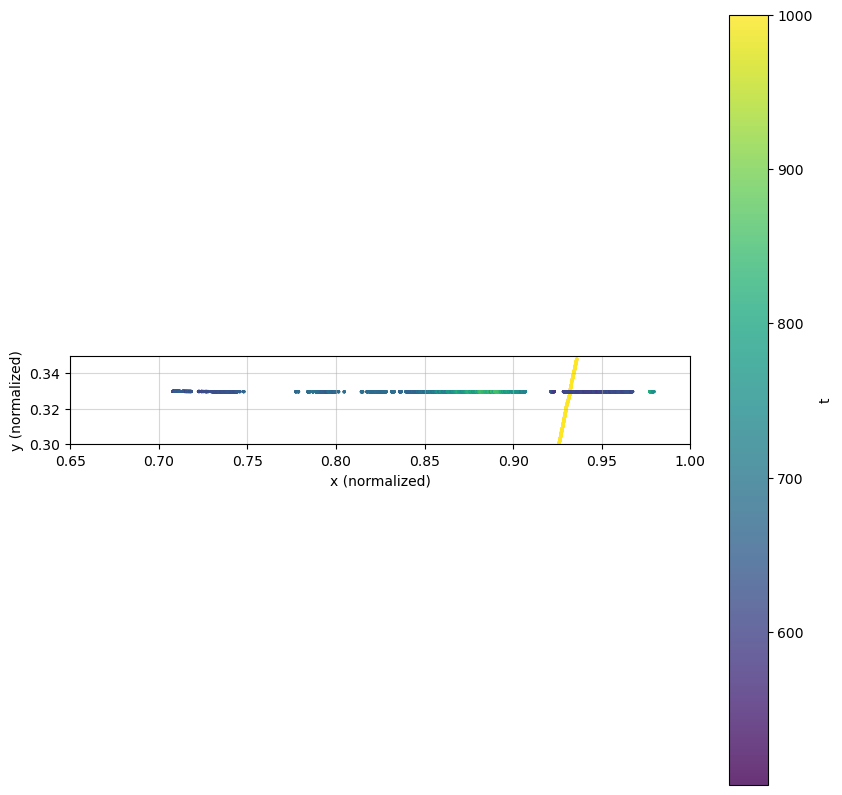

In [21]:
bedmap123_ross_onshelf_rm1[outlier_mask]

# Plot zoomed region
fig, ax = plt.subplots(figsize = (10, 10))

sc = ax.scatter(
    bedmap123_ross_onshelf_rm1[outlier_mask]["x_norm"], 
    bedmap123_ross_onshelf_rm1[outlier_mask]["y_norm"], 
    c = bedmap123_ross_onshelf_rm1[outlier_mask]["t_fa"], 
    s = 1.5, alpha = 0.8, cmap = "viridis",
    vmax = 1000
)

ax.set_xlabel("x (normalized)")
ax.set_ylabel("y (normalized)")
ax.set_aspect("equal")
ax.grid(True, alpha = 0.5)
ax.set_xlim(zoom_x_min, zoom_x_max)
ax.set_ylim(zoom_y_min, zoom_y_max)
plt.colorbar(sc, ax = ax, label = "t")
plt.show()

In [22]:
# All from LDEO_2015_ROSETTA_AIR_BM3.csv
# Remove and overwrite
bedmap123_ross_onshelf_rm2 = bedmap123_ross_onshelf_rm1[~ outlier_mask]
# takes ~ 2 min
# bedmap123_ross_onshelf_rm2.to_csv("data/bedmap123_ross_onshelf_3M.csv", index = False)

# Outlier removal 3: Zoom into vertical mid right

In [23]:
zoom_x_min = 0.9
zoom_x_max = 1.0
zoom_y_min = 0.25
zoom_y_max = 0.45

# Apply bounding box mask
mask = (
    (bedmap123_ross_onshelf_rm2["x_norm"] >= zoom_x_min) & (bedmap123_ross_onshelf_rm2["x_norm"] <= zoom_x_max) &
    (bedmap123_ross_onshelf_rm2["y_norm"] >= zoom_y_min) & (bedmap123_ross_onshelf_rm2["y_norm"] <= zoom_y_max)
    # & (bedmap123_ross_onshelf["t_fa"] > 2000)
)

bedmap123_zoom = bedmap123_ross_onshelf_rm2[mask]

print(bedmap123_zoom.shape)

(168498, 12)


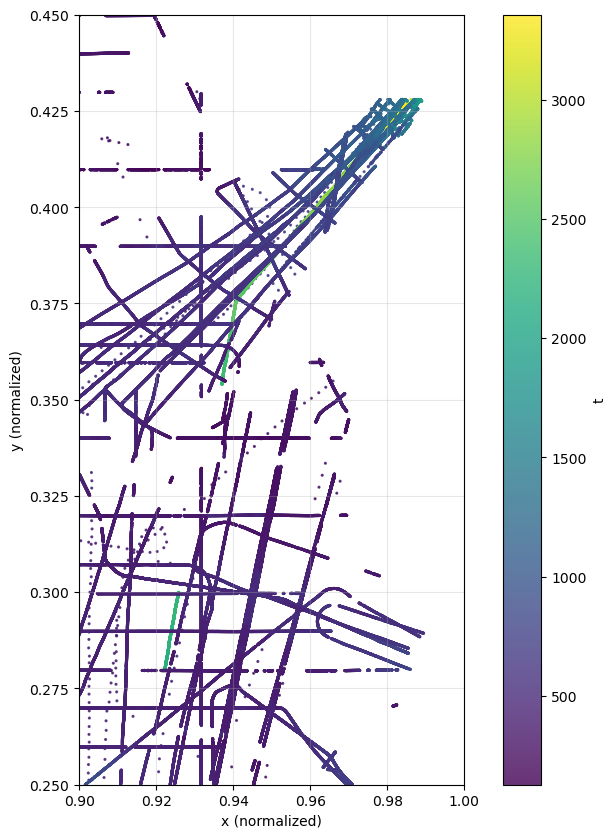

In [24]:
# Plot zoomed region
fig, ax = plt.subplots(figsize = (10, 10))

sc = ax.scatter(
    bedmap123_zoom["x_norm"], 
    bedmap123_zoom["y_norm"], 
    c = bedmap123_zoom["t_fa"], 
    s = 1.5, alpha = 0.8, cmap = "viridis"
)

ax.set_xlabel("x (normalized)")
ax.set_ylabel("y (normalized)")
ax.set_aspect("equal")
ax.grid(True, alpha = 0.3)
ax.set_xlim(zoom_x_min, zoom_x_max)
ax.set_ylim(zoom_y_min, zoom_y_max)
plt.colorbar(sc, ax = ax, label = "t")
plt.show()

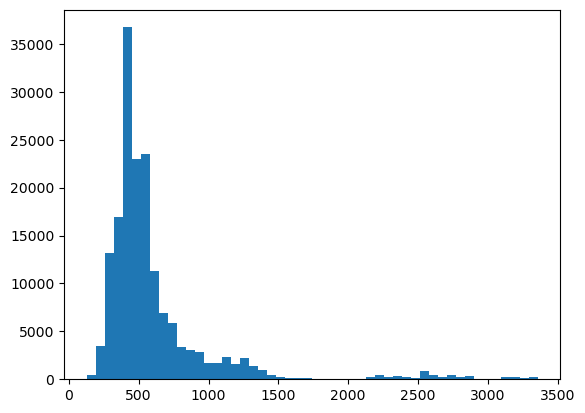

In [25]:
# clear bimodal distribution
plt.hist(bedmap123_zoom["t_fa"], bins = 50)
plt.show()

In [26]:
outlier_mask = (
    (bedmap123_ross_onshelf_rm2["x_norm"] >= zoom_x_min) & (bedmap123_ross_onshelf_rm2["x_norm"] <= zoom_x_max) &
    (bedmap123_ross_onshelf_rm2["y_norm"] >= zoom_y_min) & (bedmap123_ross_onshelf_rm2["y_norm"] <= zoom_y_max) &
    (bedmap123_ross_onshelf_rm2["t_fa"] > 1950)
)

In [27]:
print("Removing N =", bedmap123_ross_onshelf_rm2[outlier_mask].shape[0], "observation.")

Removing N = 4806 observation.


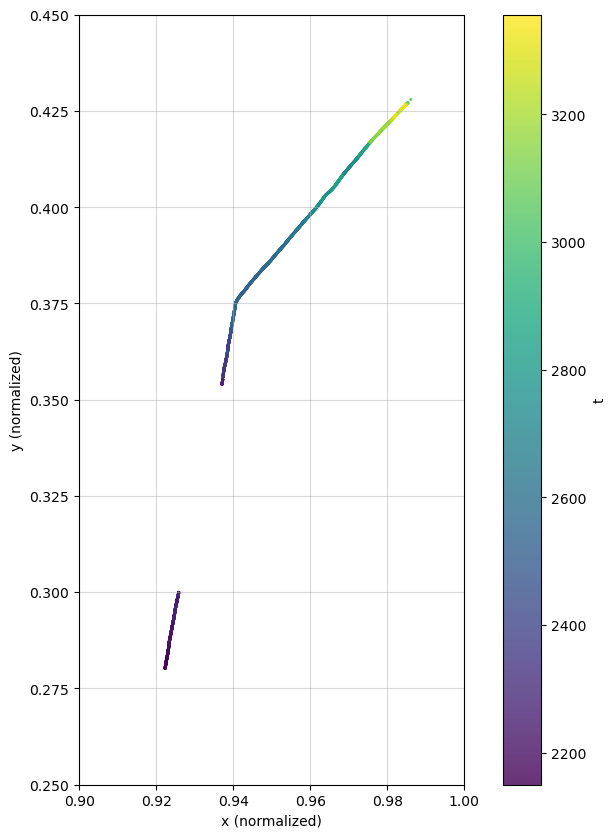

In [28]:
# See outliers
fig, ax = plt.subplots(figsize = (10, 10))

sc = ax.scatter(
    bedmap123_ross_onshelf_rm2[outlier_mask]["x_norm"], 
    bedmap123_ross_onshelf_rm2[outlier_mask]["y_norm"], 
    c = bedmap123_ross_onshelf_rm2[outlier_mask]["t_fa"], 
    s = 1.5, alpha = 0.8, cmap = "viridis"
)

# NOTE: We already remove the middle part
ax.set_xlabel("x (normalized)")
ax.set_ylabel("y (normalized)")
ax.set_aspect("equal")
ax.grid(True, alpha = 0.5)
ax.set_xlim(zoom_x_min, zoom_x_max)
ax.set_ylim(zoom_y_min, zoom_y_max)
plt.colorbar(sc, ax = ax, label = "t")
plt.show()

In [29]:
# All from BAS_2007_AGAP_AIR_BM2.csv
# Remove and overwrite
bedmap123_ross_onshelf_rm3 = bedmap123_ross_onshelf_rm2[~ outlier_mask]
# takes ~ 2 min
# Now actually save
# bedmap123_ross_onshelf_rm3.to_csv("data/bedmap123_ross_onshelf_3M.csv", index = False)

# Outlier removal 4: Zoom into dyagonal

In [30]:
zoom_x_min = 0.88
zoom_x_max = 0.94
zoom_y_min = 0.241
zoom_y_max = 0.285

# Apply bounding box mask
mask = (
    (bedmap123_ross_onshelf_rm3["x_norm"] >= zoom_x_min) & (bedmap123_ross_onshelf_rm3["x_norm"] <= zoom_x_max) &
    (bedmap123_ross_onshelf_rm3["y_norm"] >= zoom_y_min) & (bedmap123_ross_onshelf_rm3["y_norm"] <= zoom_y_max)
)

bedmap123_zoom = bedmap123_ross_onshelf_rm3[mask]

print(bedmap123_zoom.shape)

(35116, 12)


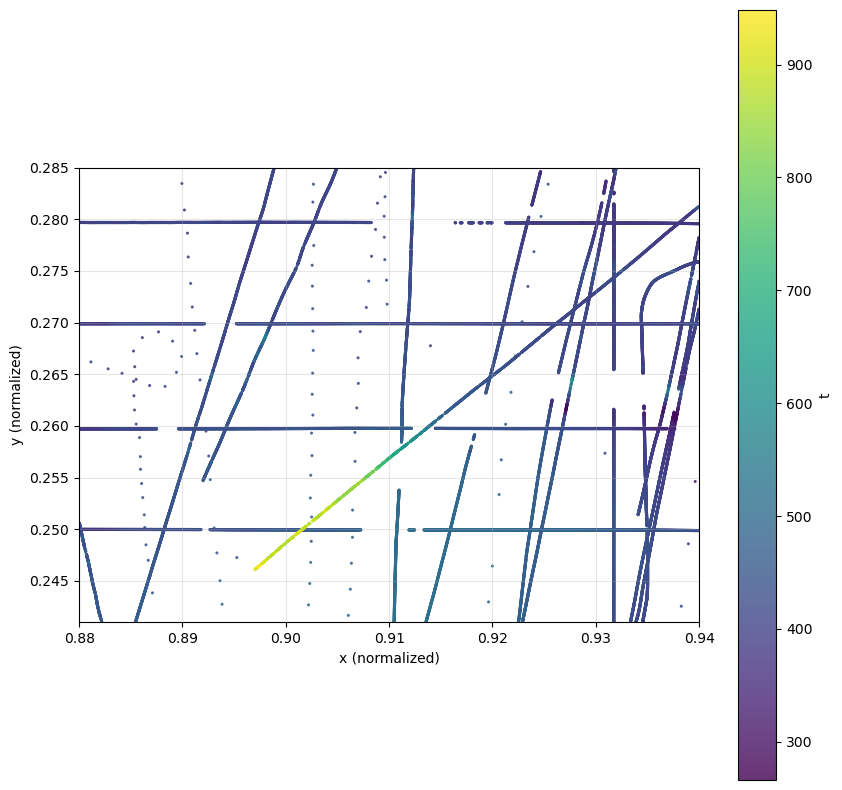

In [31]:
# Plot zoomed region
fig, ax = plt.subplots(figsize = (10, 10))

sc = ax.scatter(
    bedmap123_zoom["x_norm"], 
    bedmap123_zoom["y_norm"], 
    c = bedmap123_zoom["t_fa"], 
    s = 1.5, alpha = 0.8, cmap = "viridis"
)

ax.set_xlabel("x (normalized)")
ax.set_ylabel("y (normalized)")
ax.set_aspect("equal")
ax.grid(True, alpha = 0.3)
ax.set_xlim(zoom_x_min, zoom_x_max)
ax.set_ylim(zoom_y_min, zoom_y_max)
plt.colorbar(sc, ax = ax, label = "t")
plt.show()

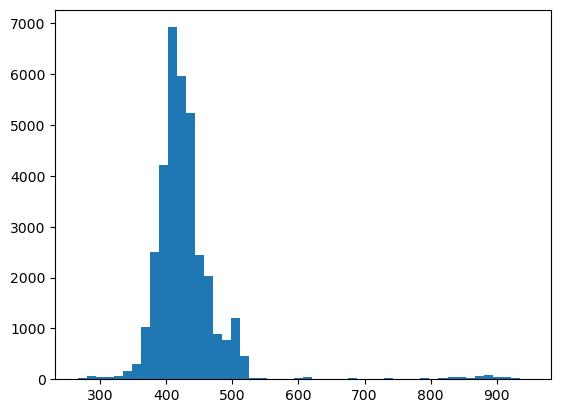

In [32]:
# clear bimodal distribution
plt.hist(bedmap123_zoom["t_fa"], bins = 50)
plt.show()

In [33]:
outlier_mask = (
    (bedmap123_ross_onshelf_rm3["x_norm"] >= zoom_x_min) & (bedmap123_ross_onshelf_rm3["x_norm"] <= zoom_x_max) &
    (bedmap123_ross_onshelf_rm3["y_norm"] >= zoom_y_min) & (bedmap123_ross_onshelf_rm3["y_norm"] <= zoom_y_max) &
    (bedmap123_ross_onshelf_rm3["t_fa"] > 600)
)

print("Removing N =", bedmap123_ross_onshelf_rm3[outlier_mask].shape[0], "observation.")

Removing N = 637 observation.


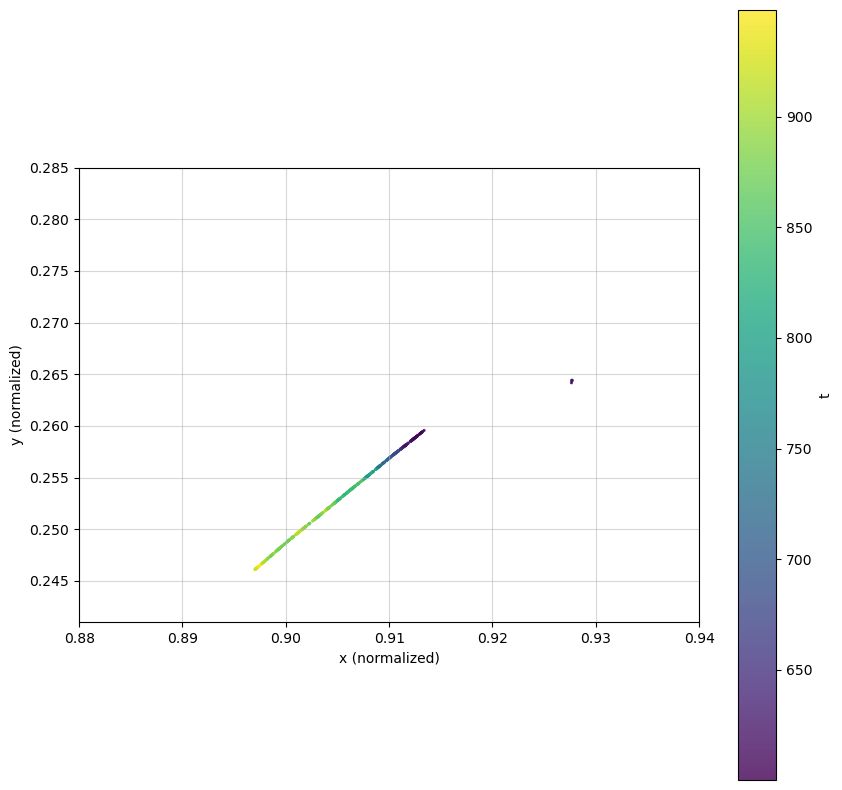

In [34]:
# See outliers
fig, ax = plt.subplots(figsize = (10, 10))

sc = ax.scatter(
    bedmap123_ross_onshelf_rm3[outlier_mask]["x_norm"], 
    bedmap123_ross_onshelf_rm3[outlier_mask]["y_norm"], 
    c = bedmap123_ross_onshelf_rm3[outlier_mask]["t_fa"], 
    s = 1.5, alpha = 0.8, cmap = "viridis"
)

# NOTE: We already remove the middle part
ax.set_xlabel("x (normalized)")
ax.set_ylabel("y (normalized)")
ax.set_aspect("equal")
ax.grid(True, alpha = 0.5)
ax.set_xlim(zoom_x_min, zoom_x_max)
ax.set_ylim(zoom_y_min, zoom_y_max)
plt.colorbar(sc, ax = ax, label = "t")
plt.show()

In [35]:
# All from UTIG_2010_ICECAP_AIR_BM3.csv
# Remove and overwrite
bedmap123_ross_onshelf_rm4 = bedmap123_ross_onshelf_rm3[ ~ outlier_mask]
# takes ~ 2 min
# Now actually save
bedmap123_ross_onshelf_rm4.to_csv("data/bedmap123_ross_onshelf_3M.csv", index = False)

# Check another area

In [36]:
# Plausible
zoom_x_min = 0.5
zoom_x_max = 0.6
zoom_y_min = 0.0
zoom_y_max = 0.4

# Removal 4: successful
zoom_x_min = 0.85
zoom_x_max = 0.95
zoom_y_min = 0.2
zoom_y_max = 0.3

# bottom right: all a okay
zoom_x_min = 0.7
zoom_x_max = 1.0
zoom_y_min = 0.0
zoom_y_max = 0.28

# problem area: still some funny values
zoom_x_min = 0.7
zoom_x_max = 0.75
zoom_y_min = 0.325
zoom_y_max = 0.35

# ice streams: plausible
zoom_x_min = 0.6
zoom_x_max = 0.8
zoom_y_min = 0.6
zoom_y_max = 0.8

# mid bottom: plausible but some gaps
zoom_x_min = 0.5
zoom_x_max = 0.7
zoom_y_min = 0.0
zoom_y_max = 0.4

# Apply bounding box mask
mask = (
    (bedmap123_ross_onshelf_rm4["x_norm"] >= zoom_x_min) & (bedmap123_ross_onshelf_rm4["x_norm"] <= zoom_x_max) &
    (bedmap123_ross_onshelf_rm4["y_norm"] >= zoom_y_min) & (bedmap123_ross_onshelf_rm4["y_norm"] <= zoom_y_max)
)

bedmap123_zoom = bedmap123_ross_onshelf_rm4[mask]

print(bedmap123_zoom.shape)

(395782, 12)


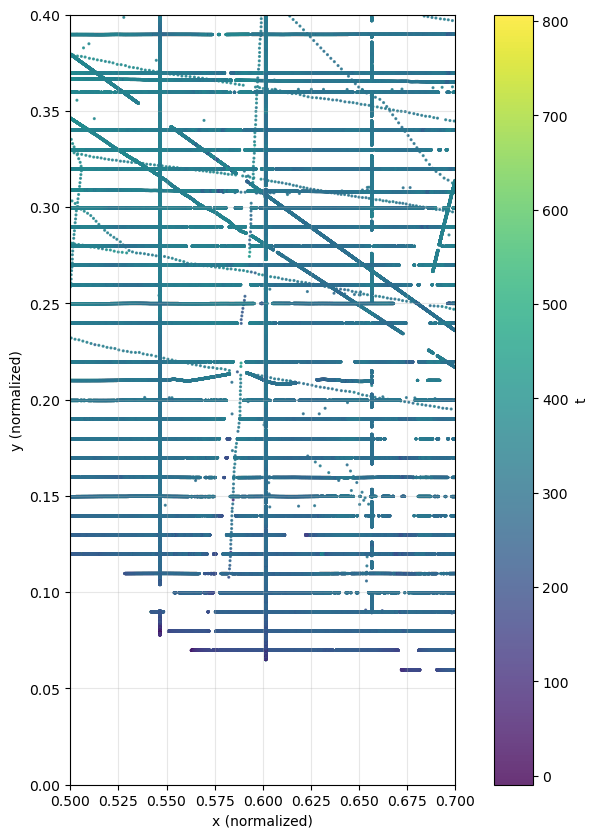

In [37]:
# Plot zoomed region
fig, ax = plt.subplots(figsize = (10, 10))

sc = ax.scatter(
    bedmap123_zoom["x_norm"], 
    bedmap123_zoom["y_norm"], 
    c = bedmap123_zoom["t_fa"], 
    s = 1.5, alpha = 0.8, cmap = "viridis"
)

ax.set_xlabel("x (normalized)")
ax.set_ylabel("y (normalized)")
ax.set_aspect("equal")
ax.grid(True, alpha = 0.3)
ax.set_xlim(zoom_x_min, zoom_x_max)
ax.set_ylim(zoom_y_min, zoom_y_max)
plt.colorbar(sc, ax = ax, label = "t")
plt.show()

# Final vis

(32400, 12)


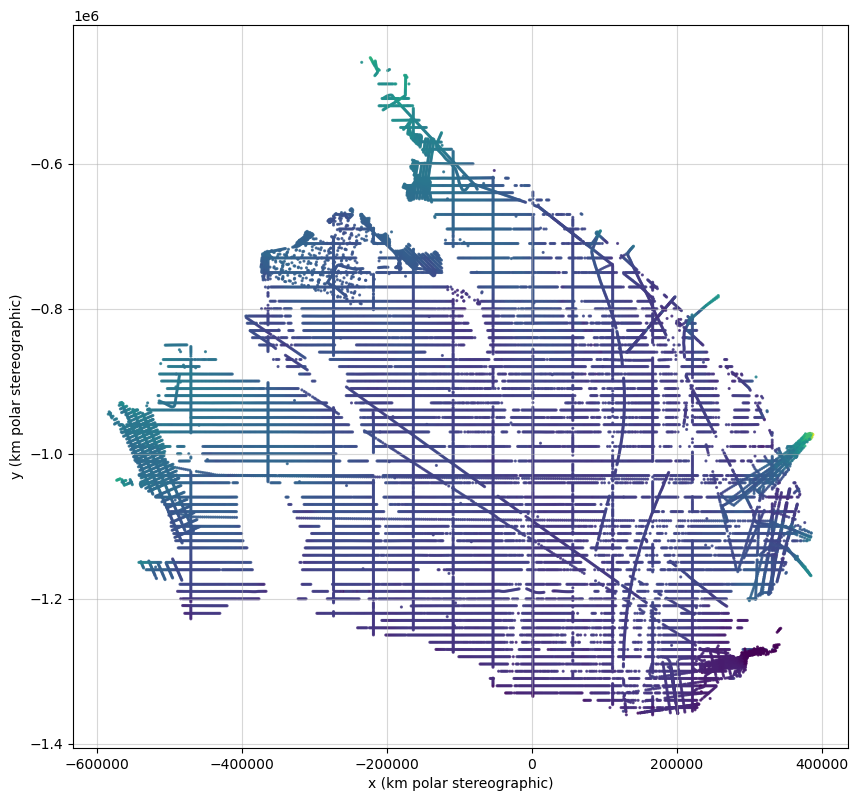

In [39]:
SUBSAMPLE_RATE = 100
# NOTE: Start with cleaned data
# subsample to reduce number of data points
bedmap123_ross_onshelf_ss = bedmap123_ross_onshelf_rm4[::SUBSAMPLE_RATE]
print(bedmap123_ross_onshelf_ss.shape)

fig, ax = plt.subplots(figsize = (10, 10))

ax.scatter(
    bedmap123_ross_onshelf_ss['x'], 
    bedmap123_ross_onshelf_ss['y'], 
    c = bedmap123_ross_onshelf_ss['t_fa'], 
    s = 1.5, alpha = 0.8, cmap = 'viridis')

# Optional: label axes to clarify units
ax.set_xlabel("x (km polar stereographic)")
ax.set_ylabel("y (km polar stereographic)")
ax.set_aspect('equal')
plt.savefig("figures/ice_thickness_points_onshelf.png", dpi = 300, bbox_inches = "tight")
ax.grid(True, alpha = 0.5)